<a href="https://colab.research.google.com/github/shivamswarnkar/Image-Classifier/blob/master/cifar10_cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

In [10]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Load and Transform Data


In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [0]:
# Define Transforms (Normalize + Augmentation)
training_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomRotation(30),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
                                        ])

test_transform = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
                                        ])

In [3]:
# Download CIFAR10 Data
train_data = datasets.CIFAR10('data', train=True, download=True, 
                              transform=training_transform)
test_data = datasets.CIFAR10('data', train=False, download=True, 
                             transform=test_transform)

0it [00:00, ?it/s]

170500096it [00:04, 35645680.31it/s]                               


Files already downloaded and verified


In [0]:
# precentage of training set to use as validation data
valid_size = 0.2 

# training indices that will be used for validation
num_train = len(train_data)
indx = list(range(num_train))
np.random.shuffle(indx)
split_indx = int(np.floor(valid_size * num_train))
train_indx, valid_indx = indx[split_indx:], indx[:split_indx]

# setup samplers
train_sampler = SubsetRandomSampler(train_indx)
valid_sampler = SubsetRandomSampler(valid_indx)

In [0]:
# how many samples per batch to load
batch_size = 32

# setup Data Loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [0]:
# image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Util Functions for Visualization

In [0]:
import matplotlib.pyplot as plt
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

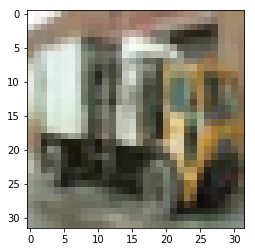

In [25]:
imshow(iter(train_loader).next()[0][0])

# Define the Network Architecture

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    
    # Convolutional layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    
    # max pooling layer
    self.pool = nn.MaxPool2d(2,2)
    
    # Fully-connected NN; First input=
    self.fc1 = nn.Linear(4*4*64, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)
    
    # dropout
    self.dropout = nn.Dropout(p=0.2)
  
  
  def forward(self, x):
    
    # conv layers
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    
    # flatten image
    x = x.view(-1, 64*4*4)
    
    # fc layers
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    
    
    # output
    x = F.log_softmax(self.fc3(x), dim=1)
    
    
    return x

# Train & Validate

In [0]:
from torch import optim

In [0]:
# setup model
model = Classifier()

# move model to GPU if available
model.to(device)

#Loss and Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [50]:
epochs = 50
train_losses, valid_losses = [], []
min_valid_loss = np.Inf

# train
for e in range(epochs):
  
  # turn on dropout
  model.train()
  
  # reset loss value for current epoch
  train_loss = 0
  
  
  # train
  for images, labels in train_loader:
    optimizer.zero_grad()
    
    # move data to GPU if available
    images, labels = images.to(device), labels.to(device)
    
    # calc loss
    loss = criterion(model(images), labels)
    
    # back prop
    loss.backward()
    
    # update weights & bias
    optimizer.step()
    
    # add to total loss
    train_loss += loss.item()
  
  
  # validate; turn off gradient calc
  with torch.no_grad():
    
    # turn off dropout
    model.eval()
    
    
    # reset loss value for current epoch
    valid_loss = 0
    
    # validate
    for images, labels in valid_loader:
      
      # move data to GPU if available
      images, labels = images.to(device), labels.to(device)
      
      # forward pass & update loss
      valid_loss += criterion(model(images), labels).item()
    
  
  # append current loss to array
  train_losses.append(train_loss/len(train_loader))
  valid_losses.append(valid_loss/len(valid_loader))
  
  # print status
  print(f'Epoch {e+1}/{epochs}: Train Loss: {train_losses[-1]:.3f}  Validation Loss: {valid_losses[-1]:.3f}')
  
  # check if model should be saved
  if valid_losses[-1] < min_valid_loss:
    print('----Validation Loss Decreased. Saving Model----')
    torch.save(model.state_dict(), 'cifar10_cnn_classifier_checkpoint.pth')
    min_valid_loss = valid_losses[-1]
    
    


Epoch 1/50: Train Loss: 1.921  Validation Loss: 1.885
----Validation Loss Decreased. Saving Model----
Epoch 2/50: Train Loss: 1.911  Validation Loss: 1.865
----Validation Loss Decreased. Saving Model----
Epoch 3/50: Train Loss: 1.913  Validation Loss: 1.851
----Validation Loss Decreased. Saving Model----
Epoch 4/50: Train Loss: 1.912  Validation Loss: 1.854
Epoch 5/50: Train Loss: 1.914  Validation Loss: 1.908
Epoch 6/50: Train Loss: 1.905  Validation Loss: 1.841
----Validation Loss Decreased. Saving Model----
Epoch 7/50: Train Loss: 1.908  Validation Loss: 1.851
Epoch 8/50: Train Loss: 1.917  Validation Loss: 1.837
----Validation Loss Decreased. Saving Model----
Epoch 9/50: Train Loss: 1.907  Validation Loss: 1.854
Epoch 10/50: Train Loss: 1.932  Validation Loss: 1.868
Epoch 11/50: Train Loss: 1.899  Validation Loss: 1.820
----Validation Loss Decreased. Saving Model----
Epoch 12/50: Train Loss: 1.895  Validation Loss: 1.835
Epoch 13/50: Train Loss: 1.899  Validation Loss: 1.878
Epoch 

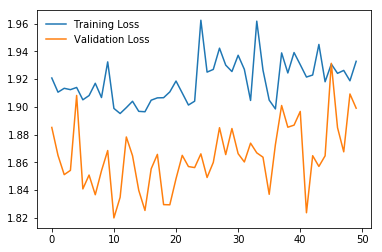

In [56]:
# plotting Validation & Training Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)

# Loading Best Model + Saving to Google Drive

In [51]:
# load the best saved model
state_dict = torch.load('cifar10_cnn_classifier_checkpoint.pth')
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# saving best model to google drive
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(model.state_dict(), '/content/gdrive/My Drive/cifar10_cnn_classifier.pth')

# Test Accuracy

In [55]:
# load the best saved model from local storage
state_dict = torch.load('cifar10_cnn_classifier_checkpoint.pth')
model.load_state_dict(state_dict)

# load the best saved model from Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# state_dict = torch.load('/content/gdrive/My Drive/cifar10_cnn_classifier.pth')
# model.load_state_dict(state_dict)

# Calculate Test Loss & Accuracy
with torch.no_grad():
  model.eval()
  test_loss = 0
  accuracy = 0
  for images, labels in test_loader:
    
    # move data to GPU if available
    images, labels = images.to(device), labels.to(device)
    
    # forward pass
    log_ps = model(images)
    
    # calculate loss
    test_loss += criterion(log_ps, labels)
    
    # calc accuracy
    _, top_class = torch.exp(log_ps).topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  
  # print results
  print(f'Test Loss={test_loss/len(test_loader):.3f}  Accuracy:{100*accuracy/len(test_loader):.3f}%')

Test Loss=1.787  Accuracy:33.167%
